### JetInferenceP2a.ipynb for inverse problem 
### Predicting the [U, V, P, uu, uv, vv, ww] using all the info on anchor points and BCs on wall/freestream
### Distribution of anchor points can be controlled

In [1]:
import deepxde as dde
import numpy as np      
# Backend tensorflow.compat.v1 or tensorflow
from deepxde.backend import tf
# Backend pytorch
# import torch
import scipy
import h5py
from scipy import interpolate
import matplotlib.pyplot as plt
import scipy.io
from scipy.spatial import KDTree
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
from matplotlib.backends.backend_pdf import PdfPages

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



In [2]:
def find_nearest1d(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

In [3]:
def find_nearest2d(array, value):
    array = np.asarray(array)
    idx   = np.zeros((np.size(value)))
    for j in range(0,np.size(value)):
        idx[j] = (np.abs(array - value[j])).argmin()
    return idx

### 1. Loading and pre-processing the data

In [4]:
with open('JetCopy.dat', 'r') as f:
    a = np.array([float(field) for field in f.read().split()])

N  = 241*141
Xg  = a[0:1*N]
Xfull  = np.reshape(Xg,(241, 141),order='F').T
Yg  = a[1*N:2*N]
Yfull  = np.reshape(Yg,(241, 141),order='F').T
Ug  = a[2*N:3*N]
Ufull  = np.reshape(Ug,(241, 141),order='F').T
Vg  = a[3*N:4*N]
Vfull  = np.reshape(Vg,(241, 141),order='F').T
Wg  = a[4*N:5*N]
Wfull  = np.reshape(Wg,(241, 141),order='F').T
uug = a[5*N:6*N]
uufull = np.reshape(uug,(241, 141),order='F').T
vvg = a[6*N:7*N]
vvfull = np.reshape(vvg,(241, 141),order='F').T
wwg = a[7*N:8*N]
wwfull = np.reshape(wwg,(241, 141),order='F').T
uvg = a[8*N:9*N]
uvfull = np.reshape(uvg,(241, 141),order='F').T
uwg = a[9*N:10*N]
uwfull = np.reshape(uwg,(241, 141),order='F').T
vwg = a[10*N:11*N]
vwfull = np.reshape(vwg,(241, 141),order='F').T

In [5]:
## Taking only the upper portion of the axisymmetric data

Xr = Xfull[70:-1,:]
Yr = Yfull[70:-1,:]
Ur = Ufull[70:-1,:]
Vr = Vfull[70:-1,:]
Wr = Wfull[70:-1,:]
uur = uufull[70:-1,:]
vvr = vvfull[70:-1,:]
wwr = wwfull[70:-1,:]
uvr = uvfull[70:-1,:]
uwr = uwfull[70:-1,:]
vwr = vwfull[70:-1,:]

X  = Xr[4:,:]
Y  = Yr[4:,:]
U  = Ur[4:,:]
V  = Vr[4:,:]
W  = Wr[4:,:]
uu = uur[4:,:]
vv = vvr[4:,:]
ww = wwr[4:,:]
uv = uvr[4:,:]
uw = uwr[4:,:]
vw = vwr[4:,:]

In [23]:
a=Xr[0,:-51]
a[-1]

19.89999962

In [6]:
Xgrid = X
Ygrid = Y

X_star = np.hstack((Xgrid.flatten()[:,None], Ygrid.flatten()[:,None]))

xmin = np.min(X_star[:,0:1])
xmax = np.max(X_star[:,0:1])

ymin = np.min(X_star[:,1:2])
ymax = np.max(X_star[:,1:2])

Xgrid   = np.single(X[:,:])
Ygrid   = np.single(Y[:,:])

x_coor = np.single(X[0,:]) 
y_coor = np.single(Y[:,0])


Uinf     = 1
L        = 1
nu       = 1/5601
Re       = Uinf*L/nu

Ustar    = U.flatten()[:,None]
Vstar    = V.flatten()[:,None]
uustar   = uu.flatten()[:,None]
vvstar   = vv.flatten()[:,None]
wwstar   = ww.flatten()[:,None]
uvstar   = uv.flatten()[:,None]

print('Min and max of U ',  np.amin(U), np.amax(U))
print('Min and max of V ',  np.amin(V), np.amax(V))
print('Min and max of uu ', np.amin(uustar), np.amax(uustar))
print('Min and max of vv ', np.amin(vvstar), np.amax(vvstar))
print('Min and max of uv ', np.amin(uvstar), np.amax(uvstar))
print('Min and max of ww ', np.amin(wwstar), np.amax(wwstar))

epsU  = 2*np.amax(np.abs(U))
epsV  = 2*np.amax(np.abs(V))
epsuu = 2*np.amax(np.abs(uu))
epsvv = 2*np.amax(np.abs(vv))
epsuv = 2*np.amax(np.abs(uv))
epsww = 2*np.amax(np.abs(ww))

Min and max of U  0.009607000276 1.0
Min and max of V  -0.01161000039 0.02098999918
Min and max of uu  6.202999793e-05 0.0252299998
Min and max of vv  7.288000052e-05 0.01023999974
Min and max of uv  -3.534999905e-06 0.008426999673
Min and max of ww  0.0 0.01420000009


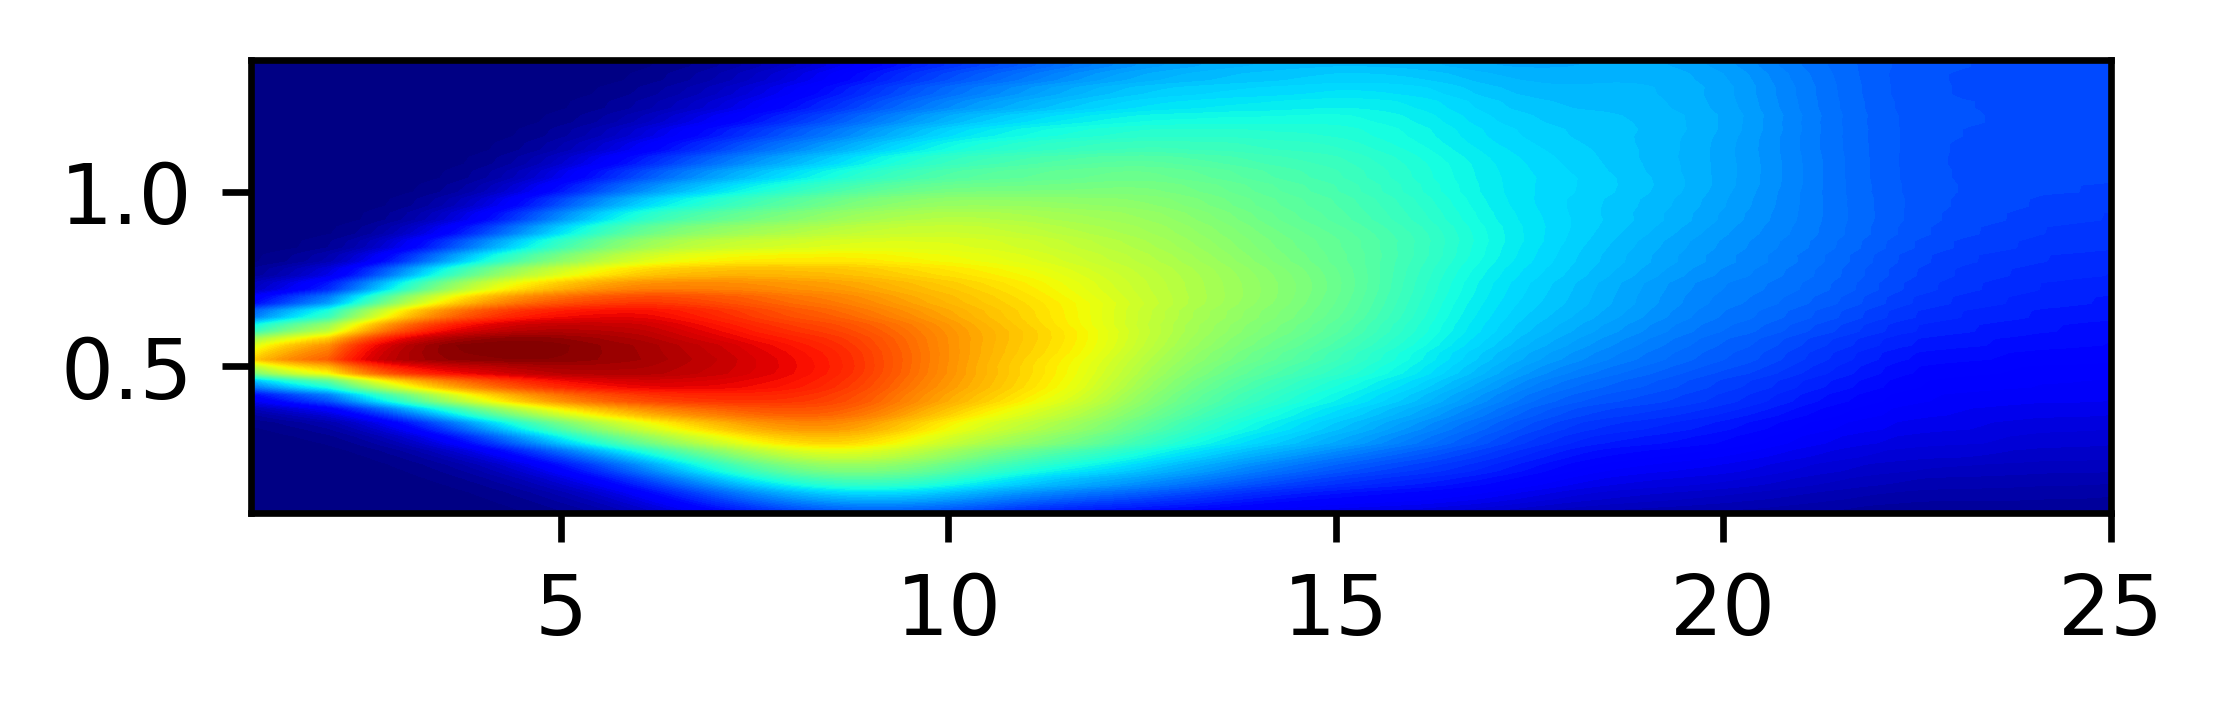

In [7]:
fig = plt.figure(figsize=(4,2.2), dpi=600)
gsp = gridspec.GridSpec(1,1)
ax = fig.add_subplot(2, 1, 1)
lvls = np.linspace(np.min(uv),np.max(uv),100)
cs0 = ax.contourf(Xgrid, Ygrid, uv, levels=lvls, cmap='jet', extend = 'both')
# ax0.set_aspect("equal")

### 2. Hyperparameters for DeepXDE network

In [8]:
### Distribution of anchor points in the domain
### Currently, the anchor points generate uniformly spaced grid in x-y direction

Nx_anchor      = 16
Ny_anchor      = 16
print('Nx and Ny anchor points ', Nx_anchor, Ny_anchor)
x_coor_anchors = np.linspace(np.amin(X_star[:,0]), np.amax(X_star[:,0]), Nx_anchor)
# y_coor_anchors = np.linspace(np.amin(X_star[:,1]), np.amax(X_star[:,1]), Ny_anchor)
y_coor_anchors = np.linspace(0.4, 0.6, Ny_anchor)
Xgrid_anchors  = np.tile(x_coor_anchors,(Ny_anchor, 1))
Ygrid_anchors  = np.tile(y_coor_anchors,(Nx_anchor, 1)).T

Nx and Ny anchor points  16 16


In [9]:
n                = 100
precision_train  = 10
precision_test   = 30
hard_constraint  = False
w                = 100

In [10]:
epochs     = 10000
parameters = [1e-3, 6, 20, "tanh"] # [lr, num_layers, num_neurons, activation_function]

# Define sine function
if dde.backend.backend_name == "tf":
    sin = dde.backend.pytorch.sin
else:
    from deepxde.backend import tf
    sin = tf.sin

learning_rate, num_dense_layers, num_dense_nodes, activation = parameters

### 3. BCs and governing equations

In [11]:
def pde(x, y):       ### Defining a set of PDEs
    
    u       = epsU*y[:,0:1]
    v       = epsV*y[:,1:2]  
    p       = (epsU*epsU)*y[:,2:3]
    uuprime = epsuu*y[:,3:4]
    uvprime = epsuv*y[:,4:5]
    vvprime = epsvv*y[:,5:6]
    wwprime = epsww*y[:,6:7]

    
    u_x       = dde.grad.jacobian(y, x, i=0, j=0)
    u_y       = dde.grad.jacobian(y, x, i=0, j=1) 
    
    v_x       = dde.grad.jacobian(y, x, i=1, j=0)
    v_y       = dde.grad.jacobian(y, x, i=1, j=1) 
    
    p_x       = dde.grad.jacobian(y, x, i=2, j=0)
    p_y       = dde.grad.jacobian(y, x, i=2, j=1) 
    
    u_xx      = dde.grad.hessian(y, x, component=0, i=0, j=0) 
    u_yy      = dde.grad.hessian(y, x, component=0, i=1, j=1)
    
    v_xx      = dde.grad.hessian(y, x, component=1, i=0, j=0) 
    v_yy      = dde.grad.hessian(y, x, component=1, i=1, j=1)
    
    uuprime_x = dde.grad.jacobian(y, x, i=2, j=0)
    uvprime_y = dde.grad.jacobian(y, x, i=3, j=1)
    uvprime_x = dde.grad.jacobian(y, x, i=3, j=0)
    vvprime_y = dde.grad.jacobian(y, x, i=4, j=1)
    
    l1 = u * u_x + v*u_y + p_x - (1/Re) * (u_xx + u_yy + u_y/x[:,1:2]) + (uuprime_x + uvprime_y + uvprime/x[:,1:2])
    l2 = u * v_x + v*v_y + p_y - (1/Re) * (v_xx + v_yy + v_y/x[:,1:2] - v/(x[:,1:2]**2)) + (uvprime_x + vvprime_y + vvprime/x[:,1:2] - wwprime/x[:,1:2])
    l3 = u_x + v_y + v/x[:,1:2]

    return l1, l2/epsV, l3

In [12]:
geom = dde.geometry.Rectangle([xmin, ymin], [xmax, ymax])
    
if hard_constraint == True:
    bc = []
else:
    
    ##-----------------------------------r=0
    fU2  = interpolate.interp1d(x_coor.squeeze(), U[0:1,:].squeeze()/epsU, kind = 'cubic')
    fV2  = interpolate.interp1d(x_coor.squeeze(), V[0:1,:].squeeze()/epsV, kind = 'cubic')
    fuu2 = interpolate.interp1d(x_coor.squeeze(), uu[0:1,:].squeeze()/epsuu, kind = 'cubic')
    fuv2 = interpolate.interp1d(x_coor.squeeze(), uv[0:1,:].squeeze()/epsuv, kind = 'cubic')
    fvv2 = interpolate.interp1d(x_coor.squeeze(), vv[0:1,:].squeeze()/epsvv, kind = 'cubic')
    fww2 = interpolate.interp1d(x_coor.squeeze(), ww[0:1,:].squeeze()/epsww, kind = 'cubic')

    bcAxis_u     =  dde.DirichletBC(geom, lambda x: fU2(x[:,0:1]),   lambda x, on_boundary:  np.isclose(x[1], ymin), component = 0)
    bcAxis_v     =  dde.DirichletBC(geom, lambda x: fV2(x[:,0:1]),   lambda x, on_boundary:  np.isclose(x[1], ymin), component = 1)
    bcAxis_uu    =  dde.DirichletBC(geom, lambda x: fuu2(x[:,0:1]),  lambda x, on_boundary:  np.isclose(x[1], ymin), component = 3)
    bcAxis_uv    =  dde.DirichletBC(geom, lambda x: fuv2(x[:,0:1]),  lambda x, on_boundary:  np.isclose(x[1], ymin), component = 4)
    bcAxis_vv    =  dde.DirichletBC(geom, lambda x: fvv2(x[:,0:1]),  lambda x, on_boundary:  np.isclose(x[1], ymin), component = 5)
    bcAxis_ww    =  dde.DirichletBC(geom, lambda x: fww2(x[:,0:1]),  lambda x, on_boundary:  np.isclose(x[1], ymin), component = 6)

    ##--------------------------------------Freestream
    fU3  = interpolate.interp1d(x_coor.squeeze(), U[-1,:].squeeze()/epsU, kind = 'cubic')
    fV3  = interpolate.interp1d(x_coor.squeeze(), V[-1,:].squeeze()/epsV, kind = 'cubic')
    fuu3 = interpolate.interp1d(x_coor.squeeze(), uu[-1,:].squeeze()/epsuu, kind = 'cubic')
    fuv3 = interpolate.interp1d(x_coor.squeeze(), uv[-1,:].squeeze()/epsuv, kind = 'cubic')
    fvv3 = interpolate.interp1d(x_coor.squeeze(), vv[-1,:].squeeze()/epsvv, kind = 'cubic')
    fww3 = interpolate.interp1d(x_coor.squeeze(), ww[-1,:].squeeze()/epsww, kind = 'cubic')

    bcFS_u       =  dde.DirichletBC(geom, lambda x: fU3(x[:,0:1]), lambda x, on_boundary:  np.isclose(x[1], ymax), component = 0)
    bcFS_v       =  dde.DirichletBC(geom, lambda x: fV3(x[:,0:1]), lambda x, on_boundary:  np.isclose(x[1], ymax), component = 1)
    bcFS_uu      =  dde.DirichletBC(geom, lambda x: fuu3(x[:,0:1]),lambda x, on_boundary:  np.isclose(x[1], ymax), component = 3)
    bcFS_uv      =  dde.DirichletBC(geom, lambda x: fuv3(x[:,0:1]),lambda x, on_boundary:  np.isclose(x[1], ymax), component = 4)
    bcFS_vv      =  dde.DirichletBC(geom, lambda x: fvv3(x[:,0:1]),lambda x, on_boundary:  np.isclose(x[1], ymax), component = 5)
    bcFS_ww      =  dde.DirichletBC(geom, lambda x: fvv3(x[:,0:1]),lambda x, on_boundary:  np.isclose(x[1], ymax), component = 6)
    
    
    
    

    bc = [bcAxis_u, bcAxis_v, bcAxis_uu, bcAxis_uv, bcAxis_vv, bcAxis_ww,
          bcFS_u, bcFS_v, bcFS_uu, bcFS_uv, bcFS_vv, bcFS_ww]

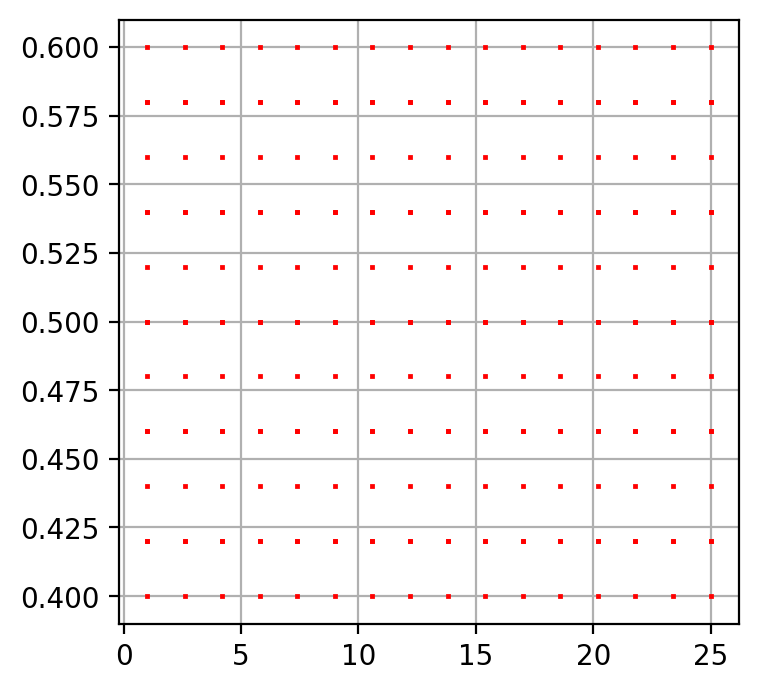

In [13]:
## Control the distribution of anchor points within the domain

X_star_anchors  = np.hstack((Xgrid_anchors.flatten()[:,None], Ygrid_anchors.flatten()[:,None]))

kdtree = KDTree(X_star)
d, idx_anchors = kdtree.query(X_star_anchors)

observe_u  = dde.PointSetBC(X_star[idx_anchors], Ustar[idx_anchors]/epsU,   component=0)
observe_v  = dde.PointSetBC(X_star[idx_anchors], Vstar[idx_anchors]/epsV,   component=1)
observe_uu = dde.PointSetBC(X_star[idx_anchors], uustar[idx_anchors]/epsuu, component=3)
observe_uv = dde.PointSetBC(X_star[idx_anchors], uvstar[idx_anchors]/epsuv, component=4)
observe_vv = dde.PointSetBC(X_star[idx_anchors], vvstar[idx_anchors]/epsvv, component=5)
observe_ww = dde.PointSetBC(X_star[idx_anchors], wwstar[idx_anchors]/epsww, component=6)

fig = plt.figure(figsize=(4,4), dpi=200)
gsp = gridspec.GridSpec(1,1)
ax0 = plt.subplot(gsp[0,0])
cs0 = plt.plot(X_star[idx_anchors,0], X_star[idx_anchors,1], 'rs', markersize=1)
# cs0 = plt.plot(X_star_anchors[:,0], X_star_anchors[:,1], 'bs', markersize=1)

plt.grid()
plt.show()

### 4. Creating and training the PINN model

In [14]:
data = dde.data.PDE(
    geom,   
    pde,     
    [bcAxis_u, bcAxis_v, bcAxis_uu, bcAxis_uv, bcAxis_vv, bcAxis_ww, bcFS_u, bcFS_v, bcFS_uu, bcFS_uv, bcFS_vv, bcFS_ww,
     observe_u, observe_v, observe_uu, observe_uv, observe_vv, observe_ww],
    train_distribution = 'uniform',
    num_domain         = n ** 2, # Domain points
    anchors            = X_star[idx_anchors,:],
    num_boundary       = n * 5, # Boundary points
    num_test           = n ** 2,
)

[25.    1.38]
[1.   0.08]


In [15]:
net = dde.maps.FNN([2] + [num_dense_nodes] * num_dense_layers + [7], activation, "Glorot uniform")

In [16]:
model = dde.Model(data, net)

if hard_constraint == True:
    model.compile("adam", lr=learning_rate)
else:
    loss_weights = [1, 1, 1,                  # Equations residual
                    w, w, w, w, w, w,          # Weights for axis BC
                    w, w, w, w, w, w,         # Weights for freestream BC
                    w, w, w, w, w, w]         # Weights for anchor points
    model.compile("adam",lr=learning_rate,loss_weights=loss_weights)

Compiling model...
Building feed-forward neural network...
'build' took 0.097810 s



/home/sheel/anaconda3/lib/python3.6/site-packages/keras/legacy_tf_layers/core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/home/sheel/anaconda3/lib/python3.6/site-packages/keras/engine/base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 2.112697 s



Initializing variables...
Training model...

Step      Train loss                                                                                                                                                                                                            Test loss                                                                                                                                                                                                             Test metric
0         [9.41e-03, 3.75e-01, 8.49e-04, 9.69e+01, 4.74e+00, 3.77e+00, 3.13e-01, 1.62e+01, 1.52e+01, 4.54e+01, 3.17e+00, 1.05e+01, 4.85e-01, 7.14e+00, 1.13e+01, 7.57e+01, 1.56e+01, 1.60e+00, 5.35e+00, 2.30e+01, 2.53e+01]    [9.29e-03, 3.23e-01, 6.85e-04, 9.69e+01, 4.74e+00, 3.77e+00, 3.13e-01, 1.62e+01, 1.52e+01, 4.54e+01, 3.17e+00, 1.05e+01, 4.85e-01, 7.14e+00, 1.13e+01, 7.57e+01, 1.56e+01, 1.60e+00, 5.35e+00, 2.30e+01, 2.53e+01]    []  
1000      [1.46e-01, 1.99e-02, 1.95e-01, 6.84e-03, 3.54e-02, 3

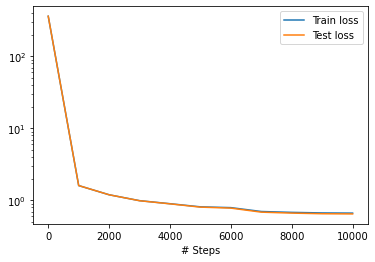

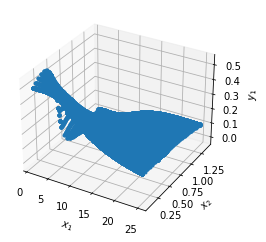

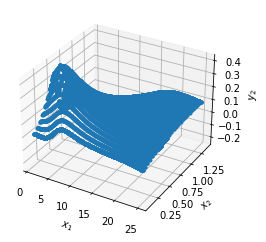

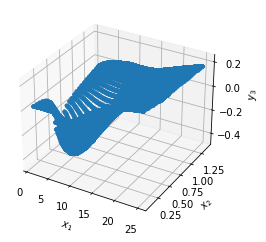

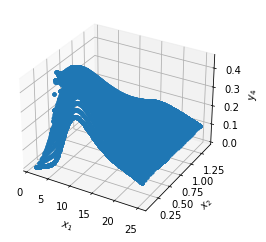

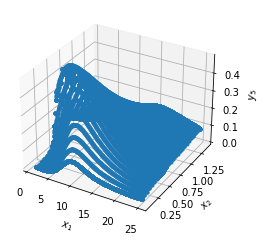

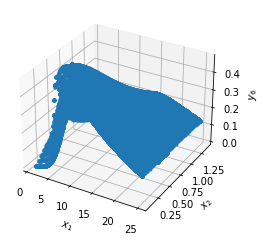

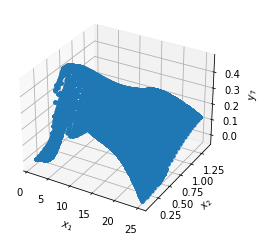

In [17]:
filename = './ModelTransBLP2a' + 'anchor' + str(Nx_anchor) + '_' + str(Ny_anchor) + 'layers'+ str(num_dense_layers) + 'lr' + str(learning_rate) + 'epochs' + str(epochs) + 'n' + str(n) + '.ckpt'
losshistory, train_state = model.train(epochs=epochs, model_save_path=filename)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

### 5. Postprocessing the model and quantifying the errors

In [18]:
output_pred = model.predict(X_star)
Upred   = output_pred[:,0:1]*epsU
Vpred   = output_pred[:,1:2]*epsV
Ppred   = output_pred[:,2:3]
uupred  = output_pred[:,3:4]*epsuu
uvpred  = output_pred[:,4:5]*epsuv
vvpred  = output_pred[:,5:6]*epsvv

Ugrid  =  np.reshape(Upred,   [np.size(Xgrid,0), np.size(Xgrid,1)])
Vgrid  =  np.reshape(Vpred,   [np.size(Xgrid,0), np.size(Xgrid,1)])
Pgrid  =  np.reshape(Ppred,   [np.size(Xgrid,0), np.size(Xgrid,1)])
uugrid =  np.reshape(uupred,  [np.size(Xgrid,0), np.size(Xgrid,1)])
uvgrid =  np.reshape(uvpred,  [np.size(Xgrid,0), np.size(Xgrid,1)])
vvgrid =  np.reshape(vvpred,  [np.size(Xgrid,0), np.size(Xgrid,1)])

error_U  = np.linalg.norm(Ustar-Upred,2)/np.linalg.norm(Ustar,2)*100
error_V  = np.linalg.norm(Vstar-Vpred,2)/np.linalg.norm(Vstar,2)*100
error_uu = np.linalg.norm(uugrid-uu,2)/np.linalg.norm(uu,2)*100
error_vv = np.linalg.norm(vvgrid-vv,2)/np.linalg.norm(vv,2)*100
error_uv = np.linalg.norm(np.abs(uvgrid)-np.abs(uv),2)/np.linalg.norm(uv,2)*100

fold = './'
filename = fold + 'global_error.txt'
np.savetxt(filename, (error_U,error_V, error_uu, error_vv, error_uv))

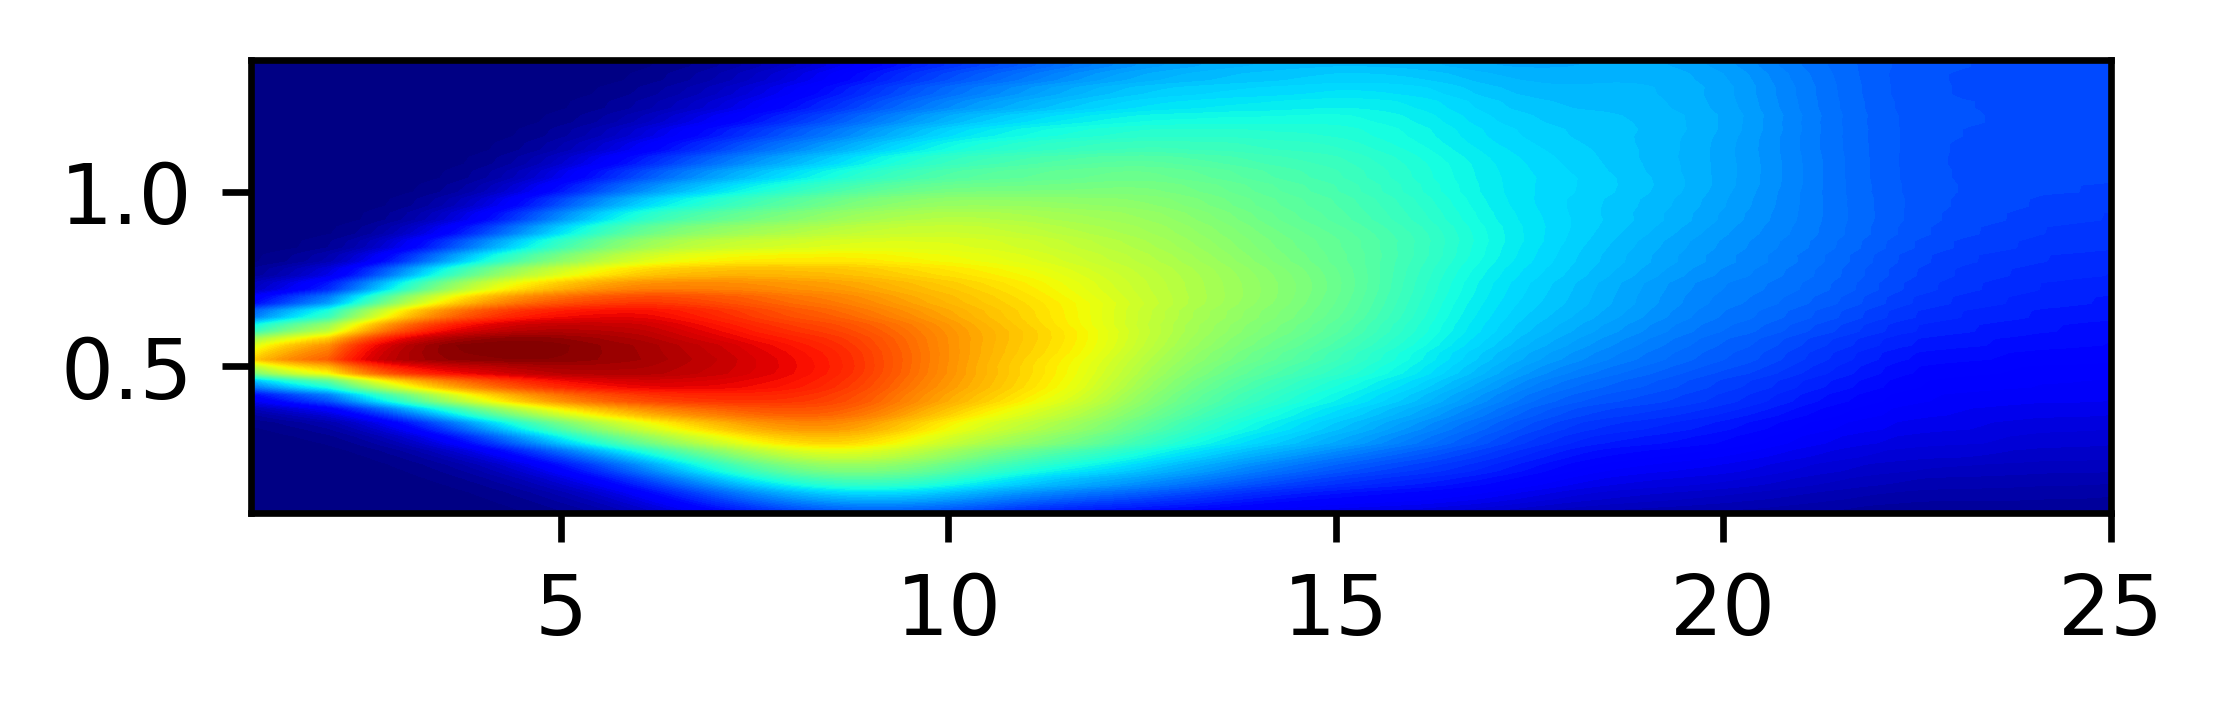

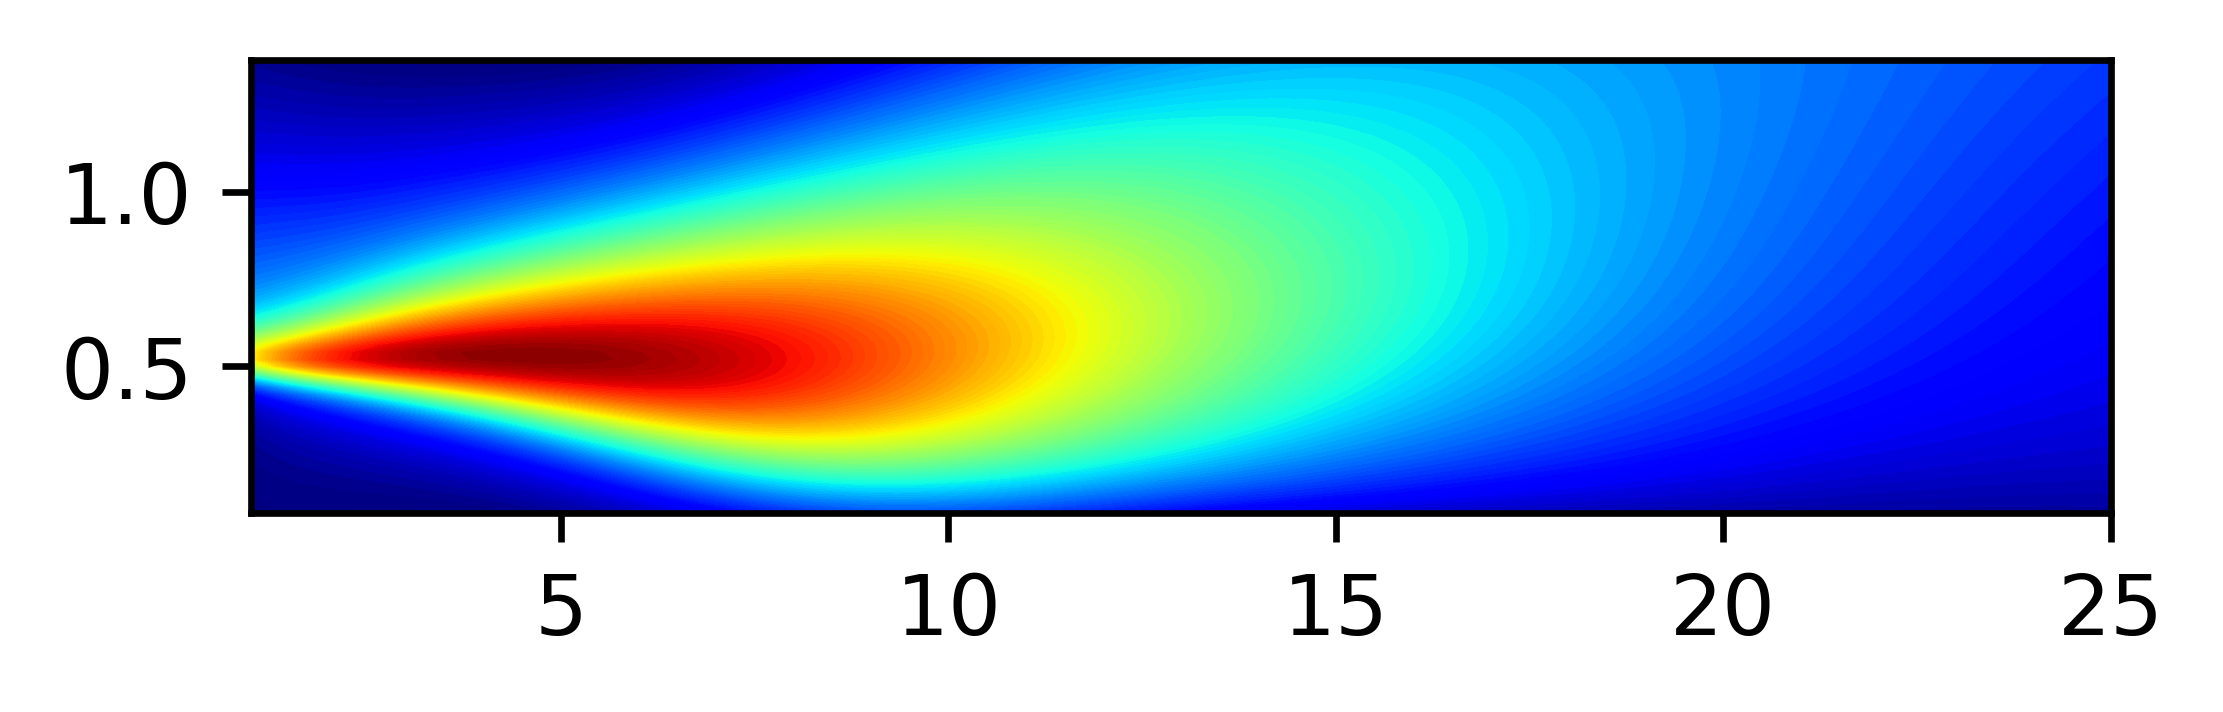

In [19]:
### Contour plots at a given station

fig = plt.figure(figsize=(4,2.2), dpi=600)
gsp = gridspec.GridSpec(1,1)
ax = fig.add_subplot(2, 1, 1)
lvls = np.linspace(np.min(uv),np.max(uv),100)
cs0 = ax.contourf(Xgrid, Ygrid, uv, levels=lvls, cmap='jet', extend = 'both')
# ax0.set_aspect("equal")

fig = plt.figure(figsize=(4,2.2), dpi=600)
gsp = gridspec.GridSpec(1,1)
ax = fig.add_subplot(2, 1, 2)
lvls = np.linspace(np.min(uv),np.max(uv),100)
cs0 = ax.contourf(Xgrid, Ygrid, uvgrid, levels=lvls, cmap='jet', extend = 'both')
# ax0.set_aspect("equal")

In [20]:
### Line plots at a given station for U, V, uu, -uv

rethetaloc = [100, 200, 400, 600, 800, 1000]
idx   = find_nearest2d(ReTheta, rethetaloc)
idx = idx.astype(int)
ThetaQuery = theta[idx]

fig, axs = plt.subplots(3, 2, figsize=(6,6), dpi=600)

for i in range(0,axs.shape[0]):
    for j in range(0, axs.shape[1]):
        count = i*(axs.shape[0]-1) + j
        axs[i, j].plot(y_coor, U[:,idx[count]], 'k-', linewidth=1)
        axs[i, j].plot(y_coor, Ugrid[:,idx[count]], 'k--', linewidth=1)
        axs[i, j].set_title('U')
        axs[i, j].set_ylim((0, 1.2))
        axs[i, j].set_xlim((0, 5*theta[idx[count]]))
        axs[i, j].grid()
fig.tight_layout()
fig.savefig(fig)

NameError: name 'ReTheta' is not defined

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(6,6), dpi=600)

for i in range(0,axs.shape[0]):
    for j in range(0, axs.shape[1]):
        count = i*(axs.shape[0]-1) + j
        axs[i, j].plot(y_coor, V[:,idx[count]], 'k-', linewidth=1)
        axs[i, j].plot(y_coor, Vgrid[:,idx[count]], 'k--', linewidth=1)
        axs[i, j].set_title('V')
        axs[i, j].set_ylim((-epsV, epsV))
        axs[i, j].set_xlim((0, 5*theta[idx[count]]))
        axs[i, j].grid()
fig.tight_layout()
fig.savefig()

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(6,6), dpi=600)
for i in range(0,axs.shape[0]):
    for j in range(0, axs.shape[1]):
        count = i*(axs.shape[0]-1) + j
        axs[i, j].plot(y_coor, uuprime[:,idx[count]], 'k-', linewidth=1)
        axs[i, j].plot(y_coor, uugrid[:,idx[count]], 'k--', linewidth=1)
        axs[i, j].set_title('uu')
        axs[i, j].set_ylim((0, epsuu))
        axs[i, j].set_xlim((0, 5*theta[idx[count]]))
        axs[i, j].grid()
fig.tight_layout()
fig.savefig()

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(6,6), dpi=600)
for i in range(0,axs.shape[0]):
    for j in range(0, axs.shape[1]):
        count = i*(axs.shape[0]-1) + j
        axs[i, j].plot(y_coor, vvprime[:,idx[count]], 'k-', linewidth=1)
        axs[i, j].plot(y_coor, vvgrid[:,idx[count]], 'k--', linewidth=1)
        axs[i, j].set_title('vv')
        axs[i, j].set_ylim((0, epsvv))
        axs[i, j].set_xlim((0, 5*theta[idx[count]]))
        axs[i, j].grid()
fig.tight_layout()
fig.savefig()

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(6,6), dpi=600)
for i in range(0,axs.shape[0]):
    for j in range(0, axs.shape[1]):
        count = i*(axs.shape[0]-1) + j
        axs[i, j].plot(y_coor, -uvprime[:,idx[count]], 'k-', linewidth=1)
        axs[i, j].plot(y_coor, -uvgrid[:,idx[count]], 'k--', linewidth=1)
        axs[i, j].set_title('uv')
        axs[i, j].set_ylim((0, epsuv))
        axs[i, j].set_xlim((0, 5*theta[idx[count]]))
        axs[i, j].grid()
fig.tight_layout()
fig.savefig()